<a href="https://colab.research.google.com/github/anders-graffe/experimentos/blob/main/%5BTopic_Model%5D_Modelado_de_t%C3%B3picos_noticias_financieras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pandas joblib pyLDAvis numpy

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
import string
stop_words = set( stopwords.words('spanish'))
stop_words.update(string.punctuation)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

# Busqueda de la frecuencia de Bigramas
from nltk.collocations import BigramCollocationFinder,BigramAssocMeasures
import pandas as pd
import numpy as np


#Graficos
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',300)

import warnings
warnings.filterwarnings("ignore")

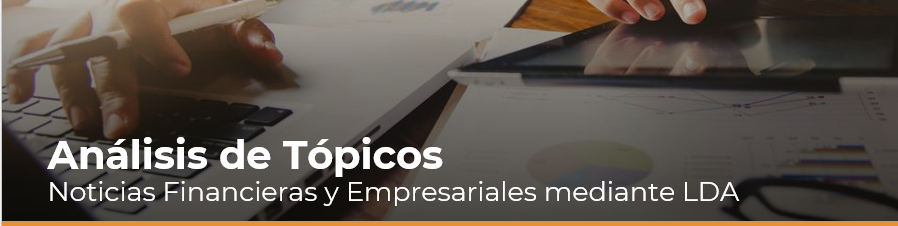

##**Datos**
Recolección de notas provenientes de diferentes sitios web relevantes en el ámbito financiero.

In [ ]:
# Importo el dataset

n1 = pd.read_csv('https://raw.githubusercontent.com/anders-graffe/experimentos/main/Modelos/Datasets/%5BTopic_Model%5D_notes_01.csv', encoding='utf-8') #Encoding
n2 = pd.read_csv('https://raw.githubusercontent.com/anders-graffe/experimentos/main/Modelos/Datasets/%5BTopic_Model%5D_notes_02.csv', encoding='utf-8')
n3= pd.read_csv('https://raw.githubusercontent.com/anders-graffe/experimentos/main/Modelos/Datasets/%5BTopic_Model%5D_notes_03.csv', encoding='utf-8')

df = pd.concat([n1, n2, n3])
df = df.iloc[:, 1:]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(df.dtypes)


title                  object
description            object
date           datetime64[ns]
tag                    object
dtype: object


In [ ]:
# Creo una caracteristica con el tamaño del titulo
df['text_text_size'] = df['description'].str.len()
df['text_text_words_count'] = df['description'].str.split().apply(len)
df=df[df['text_text_words_count']<700]
df.head()

,title,description,date,tag,text_text_size,text_text_words_count
0,Quienes apostaron contra Nvidia ya perdieron USD 5.000 millones,"Las acciones de Nvidia se dispararon un 156% desde el mínimo de octubre de 2022 hasta la actualidad, permitiendo que la compañía gane más de USD 400.000 millones de capitalización bursátil. Este comportamiento alcista benefició considerablemente a los inversores que apostaron a su favor, pero h...",2023-05-04,Empresas,2289,379
1,Los beneficios de Barrick Gold se redujeron a casi la mitad,"Barrick Gold, la minera centrada en la extracción de oro a cielo abierto más grande del mundo, informó los balances de los tres primeros meses de 2023. En primer lugar, la compañía canadiense registró ingresos por USD 2.643 millones, lo que representa una baja del 7% frente a la cifra del mismo...",2023-05-04,Empresas,2158,358
2,Qualcomm defraudó al mercado y sus acciones cayeron,"Qualcomm, la empresa estadounidense de microprocesadores, informó los balances trimestrales de la primera parte del año, impulsando a la baja el precio de sus acciones. Concretamente, la tecnológica anunció ventas por USD 9.275 millones, lo que representa una caída interanual del 17% y una cifr...",2023-05-04,Empresas,2068,323
3,La ganancia de Mercado Libre se disparó un 200%,"Mercado Libre, la compañía argentina de comercio electrónico y pagos digitales, informó los resultados financieros del primer trimestre de 2023, en los cuales se refleja un explosivo crecimiento. En primer lugar, registró ingresos por USD 3.037 millones, un 35% más que en el mismo periodo del a...",2023-05-04,Empresas,2458,403
4,Marcos Galperín apostó al rugby y compró una franquicia,"Marcos Galperin, dueño de Mercado Libre, quién ha demostrado tener un gran liderazgo en comercio virtual en la región, fundó a los Miami Sharks, un club de rugby que militará en la Major League de Estados Unidos. De acuerdo a trascendidos, el CEO del unicornio argentino accedió a la compra de e...",2023-05-03,Empresas,1365,230


In [ ]:
import plotly.express as px

px.defaults.template = "plotly_white"
color_sequence = ["#D56509"]
fig = px.histogram(df, x="text_text_words_count", histnorm='probability', marginal='box', height=600, width=800, color_discrete_sequence=color_sequence)
fig.show()

## **Limpieza del texto**

---


In [ ]:
def limpiar_texto(texto):
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tienen un solo carácter
    texto = re.sub(r'\b[a-zA-Z]\b', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Eliminar signos de puntuación y caracteres especiales
    texto = re.sub(r'[^\w\s]', '', str(texto))
    # Convertir texto a minúsculas
    texto = texto.lower()
    return texto

# se crea un atributo nuevo que va a ser el resultado de la limpieza
df["Tokens"] = df.description.apply(limpiar_texto)

df.head()

,title,description,date,tag,text_text_size,text_text_words_count,Tokens
0,Quienes apostaron contra Nvidia ya perdieron USD 5.000 millones,"Las acciones de Nvidia se dispararon un 156% desde el mínimo de octubre de 2022 hasta la actualidad, permitiendo que la compañía gane más de USD 400.000 millones de capitalización bursátil. Este comportamiento alcista benefició considerablemente a los inversores que apostaron a su favor, pero h...",2023-05-04,Empresas,2289,379,las acciones de nvidia se dispararon un 156 desde el mínimo de octubre de 2022 hasta la actualidad permitiendo que la compañía gane más de usd 400 000 millones de capitalización bursátil este comportamiento alcista benefició considerablemente los inversores que apostaron su favor pero hirió gra...
1,Los beneficios de Barrick Gold se redujeron a casi la mitad,"Barrick Gold, la minera centrada en la extracción de oro a cielo abierto más grande del mundo, informó los balances de los tres primeros meses de 2023. En primer lugar, la compañía canadiense registró ingresos por USD 2.643 millones, lo que representa una baja del 7% frente a la cifra del mismo...",2023-05-04,Empresas,2158,358,barrick gold la minera centrada en la extracción de oro cielo abierto más grande del mundo informó los balances de los tres primeros meses de 2023 en primer lugar la compañía canadiense registró ingresos por usd 2 643 millones lo que representa una baja del 7 frente la cifra del mismo periodo d...
2,Qualcomm defraudó al mercado y sus acciones cayeron,"Qualcomm, la empresa estadounidense de microprocesadores, informó los balances trimestrales de la primera parte del año, impulsando a la baja el precio de sus acciones. Concretamente, la tecnológica anunció ventas por USD 9.275 millones, lo que representa una caída interanual del 17% y una cifr...",2023-05-04,Empresas,2068,323,qualcomm la empresa estadounidense de microprocesadores informó los balances trimestrales de la primera parte del año impulsando la baja el precio de sus acciones concretamente la tecnológica anunció ventas por usd 9 275 millones lo que representa una caída interanual del 17 una cifra alineada ...
3,La ganancia de Mercado Libre se disparó un 200%,"Mercado Libre, la compañía argentina de comercio electrónico y pagos digitales, informó los resultados financieros del primer trimestre de 2023, en los cuales se refleja un explosivo crecimiento. En primer lugar, registró ingresos por USD 3.037 millones, un 35% más que en el mismo periodo del a...",2023-05-04,Empresas,2458,403,mercado libre la compañía argentina de comercio electrónico pagos digitales informó los resultados financieros del primer trimestre de 2023 en los cuales se refleja un explosivo crecimiento en primer lugar registró ingresos por usd 3 037 millones un 35 más que en el mismo periodo del año anteri...
4,Marcos Galperín apostó al rugby y compró una franquicia,"Marcos Galperin, dueño de Mercado Libre, quién ha demostrado tener un gran liderazgo en comercio virtual en la región, fundó a los Miami Sharks, un club de rugby que militará en la Major League de Estados Unidos. De acuerdo a trascendidos, el CEO del unicornio argentino accedió a la compra de e...",2023-05-03,Empresas,1365,230,marcos galperin dueño de mercado libre quién ha demostrado tener un gran liderazgo en comercio virtual en la región fundó los miami sharks un club de rugby que militará en la major league de estados unidos de acuerdo trascendidos el ceo del unicornio argentino accedió la compra de esta franquic...


## **Tokenización del texto**


---


In [ ]:
# Se  tokeniza el texto procesad. Consiste en dividir los textos en tokens o terminos individuales.


tokenizer = ToktokTokenizer()
df["Tokens"] = df.Tokens.apply(tokenizer.tokenize)

df.head()

,title,description,date,tag,text_text_size,text_text_words_count,Tokens
0,Quienes apostaron contra Nvidia ya perdieron USD 5.000 millones,"Las acciones de Nvidia se dispararon un 156% desde el mínimo de octubre de 2022 hasta la actualidad, permitiendo que la compañía gane más de USD 400.000 millones de capitalización bursátil. Este comportamiento alcista benefició considerablemente a los inversores que apostaron a su favor, pero h...",2023-05-04,Empresas,2289,379,"[las, acciones, de, nvidia, se, dispararon, un, 156, desde, el, mínimo, de, octubre, de, 2022, hasta, la, actualidad, permitiendo, que, la, compañía, gane, más, de, usd, 400, 000, millones, de, capitalización, bursátil, este, comportamiento, alcista, benefició, considerablemente, los, inversores..."
1,Los beneficios de Barrick Gold se redujeron a casi la mitad,"Barrick Gold, la minera centrada en la extracción de oro a cielo abierto más grande del mundo, informó los balances de los tres primeros meses de 2023. En primer lugar, la compañía canadiense registró ingresos por USD 2.643 millones, lo que representa una baja del 7% frente a la cifra del mismo...",2023-05-04,Empresas,2158,358,"[barrick, gold, la, minera, centrada, en, la, extracción, de, oro, cielo, abierto, más, grande, del, mundo, informó, los, balances, de, los, tres, primeros, meses, de, 2023, en, primer, lugar, la, compañía, canadiense, registró, ingresos, por, usd, 2, 643, millones, lo, que, representa, una, baj..."
2,Qualcomm defraudó al mercado y sus acciones cayeron,"Qualcomm, la empresa estadounidense de microprocesadores, informó los balances trimestrales de la primera parte del año, impulsando a la baja el precio de sus acciones. Concretamente, la tecnológica anunció ventas por USD 9.275 millones, lo que representa una caída interanual del 17% y una cifr...",2023-05-04,Empresas,2068,323,"[qualcomm, la, empresa, estadounidense, de, microprocesadores, informó, los, balances, trimestrales, de, la, primera, parte, del, año, impulsando, la, baja, el, precio, de, sus, acciones, concretamente, la, tecnológica, anunció, ventas, por, usd, 9, 275, millones, lo, que, representa, una, caída..."
3,La ganancia de Mercado Libre se disparó un 200%,"Mercado Libre, la compañía argentina de comercio electrónico y pagos digitales, informó los resultados financieros del primer trimestre de 2023, en los cuales se refleja un explosivo crecimiento. En primer lugar, registró ingresos por USD 3.037 millones, un 35% más que en el mismo periodo del a...",2023-05-04,Empresas,2458,403,"[mercado, libre, la, compañía, argentina, de, comercio, electrónico, pagos, digitales, informó, los, resultados, financieros, del, primer, trimestre, de, 2023, en, los, cuales, se, refleja, un, explosivo, crecimiento, en, primer, lugar, registró, ingresos, por, usd, 3, 037, millones, un, 35, más..."
4,Marcos Galperín apostó al rugby y compró una franquicia,"Marcos Galperin, dueño de Mercado Libre, quién ha demostrado tener un gran liderazgo en comercio virtual en la región, fundó a los Miami Sharks, un club de rugby que militará en la Major League de Estados Unidos. De acuerdo a trascendidos, el CEO del unicornio argentino accedió a la compra de e...",2023-05-03,Empresas,1365,230,"[marcos, galperin, dueño, de, mercado, libre, quién, ha, demostrado, tener, un, gran, liderazgo, en, comercio, virtual, en, la, región, fundó, los, miami, sharks, un, club, de, rugby, que, militará, en, la, major, league, de, estados, unidos, de, acuerdo, trascendidos, el, ceo, del, unicornio, a..."


## **Stop Words**


---

In [ ]:
# Se eliminan las stopwords (palabras vacías o comunes)

STOPWORDS = set(stopwords.words("spanish"))
STOPWORDS.update([' ','x','q','.', '--',',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
                  'millones','usd','año','años','trimestre','tras','vez','segundo','cada','mismo','según','través','si'])

def filtrar_stopword_digitos(tokens): # Filtra stopwords y digitos de una lista de tokens.
    return [token for token in tokens if token not in STOPWORDS
            and not token.isdigit()]

df["Tokens"] = df.Tokens.apply(filtrar_stopword_digitos)

df.head()

,title,description,date,tag,text_text_size,text_text_words_count,Tokens
0,Quienes apostaron contra Nvidia ya perdieron USD 5.000 millones,"Las acciones de Nvidia se dispararon un 156% desde el mínimo de octubre de 2022 hasta la actualidad, permitiendo que la compañía gane más de USD 400.000 millones de capitalización bursátil. Este comportamiento alcista benefició considerablemente a los inversores que apostaron a su favor, pero h...",2023-05-04,Empresas,2289,379,"[acciones, nvidia, dispararon, mínimo, octubre, actualidad, permitiendo, compañía, gane, capitalización, bursátil, comportamiento, alcista, benefició, considerablemente, inversores, apostaron, favor, hirió, gravemente, operadores, adoptaron, estrategia, bajista, consultora, datos, s3, partners, ..."
1,Los beneficios de Barrick Gold se redujeron a casi la mitad,"Barrick Gold, la minera centrada en la extracción de oro a cielo abierto más grande del mundo, informó los balances de los tres primeros meses de 2023. En primer lugar, la compañía canadiense registró ingresos por USD 2.643 millones, lo que representa una baja del 7% frente a la cifra del mismo...",2023-05-04,Empresas,2158,358,"[barrick, gold, minera, centrada, extracción, oro, cielo, abierto, grande, mundo, informó, balances, tres, primeros, meses, primer, lugar, compañía, canadiense, registró, ingresos, representa, baja, frente, cifra, periodo, efecto, sorpresa, positivo, estimaciones, wall, street, ganancia, neta, a..."
2,Qualcomm defraudó al mercado y sus acciones cayeron,"Qualcomm, la empresa estadounidense de microprocesadores, informó los balances trimestrales de la primera parte del año, impulsando a la baja el precio de sus acciones. Concretamente, la tecnológica anunció ventas por USD 9.275 millones, lo que representa una caída interanual del 17% y una cifr...",2023-05-04,Empresas,2068,323,"[qualcomm, empresa, estadounidense, microprocesadores, informó, balances, trimestrales, primera, parte, impulsando, baja, precio, acciones, concretamente, tecnológica, anunció, ventas, representa, caída, interanual, cifra, alineada, expectativas, wall, street, beneficio, total, neto, cayó, gener..."
3,La ganancia de Mercado Libre se disparó un 200%,"Mercado Libre, la compañía argentina de comercio electrónico y pagos digitales, informó los resultados financieros del primer trimestre de 2023, en los cuales se refleja un explosivo crecimiento. En primer lugar, registró ingresos por USD 3.037 millones, un 35% más que en el mismo periodo del a...",2023-05-04,Empresas,2458,403,"[mercado, libre, compañía, argentina, comercio, electrónico, pagos, digitales, informó, resultados, financieros, primer, cuales, refleja, explosivo, crecimiento, primer, lugar, registró, ingresos, periodo, anterior, estimado, analistas, inversores, wall, street, ganancia, neta, disparó, generand..."
4,Marcos Galperín apostó al rugby y compró una franquicia,"Marcos Galperin, dueño de Mercado Libre, quién ha demostrado tener un gran liderazgo en comercio virtual en la región, fundó a los Miami Sharks, un club de rugby que militará en la Major League de Estados Unidos. De acuerdo a trascendidos, el CEO del unicornio argentino accedió a la compra de e...",2023-05-03,Empresas,1365,230,"[marcos, galperin, dueño, mercado, libre, quién, demostrado, tener, gran, liderazgo, comercio, virtual, región, fundó, miami, sharks, club, rugby, militará, major, league, unidos, acuerdo, trascendidos, ceo, unicornio, argentino, accedió, compra, franquicia, junto, grupo, amigos, suma, s6, depor..."


## **LDA Model**

---




> ### **`Diccionario y Corpus`**






In [ ]:
# Importamos las librerías que vamos a necesitar
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

from gensim.models.phrases import Phrases, Phraser

# Detectar los bigramas en los tokens combinados
bigram_phrases = Phrases(df.Tokens,min_count=5)

# Aplicar los bigramas a los tokens
tokens_bigram = [bigram_phrases[doc] for doc in df.Tokens]

# Lematizar los tokens bigrama
lemmatized_tokens = [[wordnet_lemmatizer.lemmatize(token) for token in doc] for doc in tokens_bigram]

# Crear el diccionario
diccionario = Dictionary(lemmatized_tokens)
diccionario.filter_extremes(no_below=3, no_above=0.5)


# Creamos el corpus
corpus = [diccionario.doc2bow(noticia) for noticia in df.Tokens]

len(diccionario)


4967



> ### **`Ajuste del modelo`**



In [ ]:
def calculate_topic_diversity(model, corpus):
    topic_diversity = 0
    num_topics = model.num_topics

    for i in range(num_topics):
        topic_terms = model.get_topic_terms(i)
        topic_terms = [term[0] for term in topic_terms]
        topic_vector = model.get_topic_terms(i, len(topic_terms))
        topic_vector = [term[1] for term in topic_vector]

        topic_diversity += np.sum(np.outer(topic_vector, topic_vector))

    topic_diversity /= num_topics
    return topic_diversity


def calc_coherence_values(dictionary, corpus, texts, limit=12, start=1, step=1):
    coherence_values = []
    perplexity_values = []
    topic_diversity_values = []
    ponderado = []
    topicos =[]
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=0.00001, eta=0.00001, random_state=594, chunksize=35, passes=30)
        model_list.append(model)


        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        perplexity = model.log_perplexity(corpus)
        average_diversity = calculate_topic_diversity(model, corpus)
        ponderado_score = coherence_score*0.85 + average_diversity*0.15

        print("Num Topics =", num_topics, "Coherence Score =", coherence_score, "Perplexity =", perplexity, "Topic Diversity =", average_diversity, "Ponderado =",ponderado_score)

        coherence_values.append(coherence_score)
        perplexity_values.append(perplexity)
        topic_diversity_values.append(average_diversity)
        ponderado.append(ponderado_score)
        topicos.append(num_topics)

        resultados = pd.DataFrame({'Num Topics': topicos,
                                   'Coherence': coherence_values,
                                   'Perplexity': perplexity_values,
                                   'Topic Diversity': topic_diversity_values,
                                   'Ponderado': ponderado})

    max_index = ponderado.index(max(ponderado))
    best_model = model_list[max_index]


    return resultados, best_model

resultados, best_model = calc_coherence_values(dictionary = diccionario, corpus = corpus, texts = df.Tokens, start = 6, limit = 11, step = 1)

Num Topics = 6 Coherence Score = 0.5286792479774273 Perplexity = -9959.419356911107 Topic Diversity = 0.022421199052284162 Ponderado = 0.45274054063865576
Num Topics = 7 Coherence Score = 0.536040357268765 Perplexity = -9933.474147775523 Topic Diversity = 0.025711804096187865 Ponderado = 0.4594910742928784
Num Topics = 8 Coherence Score = 0.49301280234115785 Perplexity = -9977.570048568125 Topic Diversity = 0.02377568685915321 Ponderado = 0.42262723501885713
Num Topics = 9 Coherence Score = 0.47211581179356915 Perplexity = -10056.641792374443 Topic Diversity = 0.0465405218096243 Ponderado = 0.40827951829597736
Num Topics = 10 Coherence Score = 0.4638719346944601 Perplexity = -9898.472941602844 Topic Diversity = 0.06243256572633982 Ponderado = 0.40365602934924205


In [ ]:
# Obtener el índice del valor máximo de la columna 'Ponderado'
max_index = resultados['Ponderado'].idxmax()

# Crear una función para resaltar el valor máximo
def highlight_max(value):
    if value == resultados['Ponderado'].max():
        return 'background-color: #ff7f0e'
    return ''

# Aplicar la función de resaltado a la columna 'Ponderado'
formatted_table = resultados.style.applymap(highlight_max, subset=['Ponderado'])

# Mostrar el DataFrame formateado con el valor máximo resaltado
formatted_table

,Num Topics,Coherence,Perplexity,Topic Diversity,Ponderado
0,6,0.521201,-10046.426339,0.022404,0.446382
1,7,0.528178,-9933.469992,0.027192,0.453030
2,8,0.500935,-9906.384666,0.023795,0.429364
3,9,0.467590,-10083.763329,0.042467,0.403822
4,10,0.501937,-9997.918974,0.061209,0.435828


## **Asignación de tópicos**

---



In [ ]:
# Obtener los tópicos para cada documento en el corpus
topic_vectors = [best_model.get_document_topics(doc) for doc in corpus]

# Obtener los tópicos dominantes para cada documento
dominant_topic = [max(topics, key=lambda x: x[1])[0] for topics in topic_vectors]

# Asignar los tópicos dominantes al DataFrame
df['Dominant Topic'] = dominant_topic

# Obtener las palabras clave para cada tópico en el mejor modelo
topic_keywords = best_model.show_topics(num_topics=-1, num_words=10, formatted=False)

# Crear un diccionario que mapee los tópicos a sus palabras clave
topic_keywords_dict = {topic[0]: [word[0] for word in topic[1]] for topic in topic_keywords}

# Agregar una columna adicional al DataFrame para las palabras clave del tópico dominante
df['Topic Keywords'] = df['Dominant Topic'].map(topic_keywords_dict)

df[df['Dominant Topic'] == 6]

,title,description,date,tag,text_text_size,text_text_words_count,Tokens,Dominant Topic,Topic Keywords
7,¿Cambio de estrategia?: Tesla aumentó los precios de sus vehículos,"Tesla, el fabricante de vehículos eléctricos más grande del mundo, con una capitalización bursátil de aproximadamente USD 508.000 millones, anunció una suba de precios en sus dos modelos estrella. Específicamente, ahora los coches Model 3 y Model Y aumentaron USD 250 hasta los USD 40.240 y USD ...",2023-05-02,Empresas,2567,421,"[tesla, fabricante, vehículos, eléctricos, grande, mundo, capitalización, bursátil, aproximadamente, anunció, suba, precios, dos, modelos, estrella, específicamente, ahora, coches, model, model, aumentaron, unidos, respectivamente, china, vehículos, subieron, yuanes, cuestan, yuanes, yuanes, ord...",6,"[tesla, dólares, musk, precio, apple, twitter, mercado, precios, vehículos, valor]"
21,Google: ¿De qué manera celebra sus magníficos resultados?,"Alphabet Inc se pronunció luego del cierre de mercado del martes comunicando su excelente balance. Durante el encuentro, sostuvo que recomprará 70.000 millones de dólares en acciones y reportó unos ingresos en el primer trimestre mayores a lo esperado, ya que aumentó la demanda por servicios en...",2023-04-26,Empresas,2384,403,"[alphabet, inc, pronunció, luego, cierre, mercado, martes, comunicando, excelente, balance, encuentro, sostuvo, recomprará, dólares, acciones, reportó, ingresos, primer, mayores, esperado, aumentó, demanda, servicios, nube, ventas, publicidad, mantuvieron, mejores, esperado, marco, inversores, c...",6,"[tesla, dólares, musk, precio, apple, twitter, mercado, precios, vehículos, valor]"
45,"Elon Musk: ""La inteligencia artificial tiene el potencial de destruir civilizaciones""","El empresario y fundador de Tesla, SpaceX y Neuralink, Elon Musk, ha reiterado su preocupación por los peligros potenciales de la inteligencia artificial. En una entrevista con Fox News, Musk advirtió que la inteligencia artificial tiene el potencial de destruir civilizaciones, lo que la convie...",2023-04-17,Empresas,2697,412,"[empresario, fundador, tesla, spacex, neuralink, elon, musk, reiterado, preocupación, peligros, potenciales, inteligencia, artificial, entrevista, fox, news, musk, advirtió, inteligencia, artificial, potencial, destruir, civilizaciones, convierte, amenaza, grande, errores, diseño, producción, av...",6,"[tesla, dólares, musk, precio, apple, twitter, mercado, precios, vehículos, valor]"
51,¿Se arrepintió Elon Musk de comprar Twitter?,"El multimillonario Elon Musk, en un reportaje con la cadena británica BBC, habló en exclusiva sobre su resumen respecto de los seis primeros meses de su administración en la red social Twitter. El dueño de Tesla y la espacial SpaceX, adquirió en octubre de 2022 la plataforma Twitter u$s44.000 m...",2023-04-13,Empresas,1727,292,"[multimillonario, elon, musk, reportaje, cadena, británica, bbc, habló, exclusiva, resumen, respecto, seis, primeros, meses, administración, red, social, twitter, dueño, tesla, espacial, spacex, adquirió, octubre, plataforma, twitter, s44, proceso, controvertido, ocupó, opinión, pública, interna...",6,"[tesla, dólares, musk, precio, apple, twitter, mercado, precios, vehículos, valor]"
57,Tesla es reconocida como la empresa de automóviles más valiosa del mundo,"Tesla, la compañía liderada por el multimillonario Elon Musk, ha superado a Mercedes-Benz y Toyota para ocupar el primer lugar en la lista de las marcas de automóviles más valiosas del mundo. La firma fue fundada en 2003 como desarrolladora y fabricante de vehículos eléctricos y tecnologías rel...",2023-04-12,Empresas,1513,251,"[tesla, compañía, liderada, multimillonario, elon, musk, superado, mercedes, benz, toyota, ocupar, primer, lugar, lista, marcas, automóviles, valiosas, mundo, firma, fundada, desarrolladora, fabricante, vehículos, eléctricos, tecnologías, relacionadas, mismos, consultora, valoración, marcas, bra...",6,"[tesla, dólares, musk, precio, apple, tw

## **Visualización**

---



In [ ]:
from tabulate import tabulate

# Obtener los temas
topicos = best_model.print_topics()
import pyLDAvis.gensim

# Crear una lista para almacenar los temas formateados
temas_formateados = []

# Formatear cada tema y agregarlo a la lista
for topico in topicos:
    topico_formateado = [f'Tópico {topico[0]+1}', topico[1]]
    temas_formateados.append(topico_formateado)

# Crear un DataFrame a partir de los temas formateados
df_temas = pd.DataFrame(temas_formateados, columns=['Tópico', 'Palabras'])
print(df_temas)


best_model.show_topics()
lda_display = pyLDAvis.gensim.prepare(best_model, corpus, diccionario, sort_topics = False)
pyLDAvis.display(lda_display)

     Tópico   
0  Tópico 1  \
1  Tópico 2   
2  Tópico 3   
3  Tópico 4   
4  Tópico 5   
5  Tópico 6   
6  Tópico 7   

                                                                                                                                                                                        Palabras  
0      0.039*"meta" + 0.032*"nvidia" + 0.030*"microsoft" + 0.024*"tecnología" + 0.021*"disney" + 0.020*"datos" + 0.015*"inteligencia" + 0.014*"empresas" + 0.014*"alphabet" + 0.013*"plataforma"  
1              0.018*"mercado" + 0.014*"energía" + 0.012*"argentina" + 0.010*"gas" + 0.010*"país" + 0.010*"producción" + 0.009*"criptomonedas" + 0.008*"hoy" + 0.008*"capacidad" + 0.007*"nueva"  
2                      0.025*"cedears" + 0.022*"invertir" + 0.017*"comprar" + 0.016*"cuenta" + 0.015*"solo" + 0.014*"acción" + 0.014*"riesgo" + 0.013*"pueden" + 0.013*"siguen" + 0.013*"fondos"  
3  0.019*"ingresos" + 0.018*"resultados" + 0.014*"periodo" + 0.013*"acción" + 0.012*"anterior" + 0.



> ### **Wordcloud**



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:


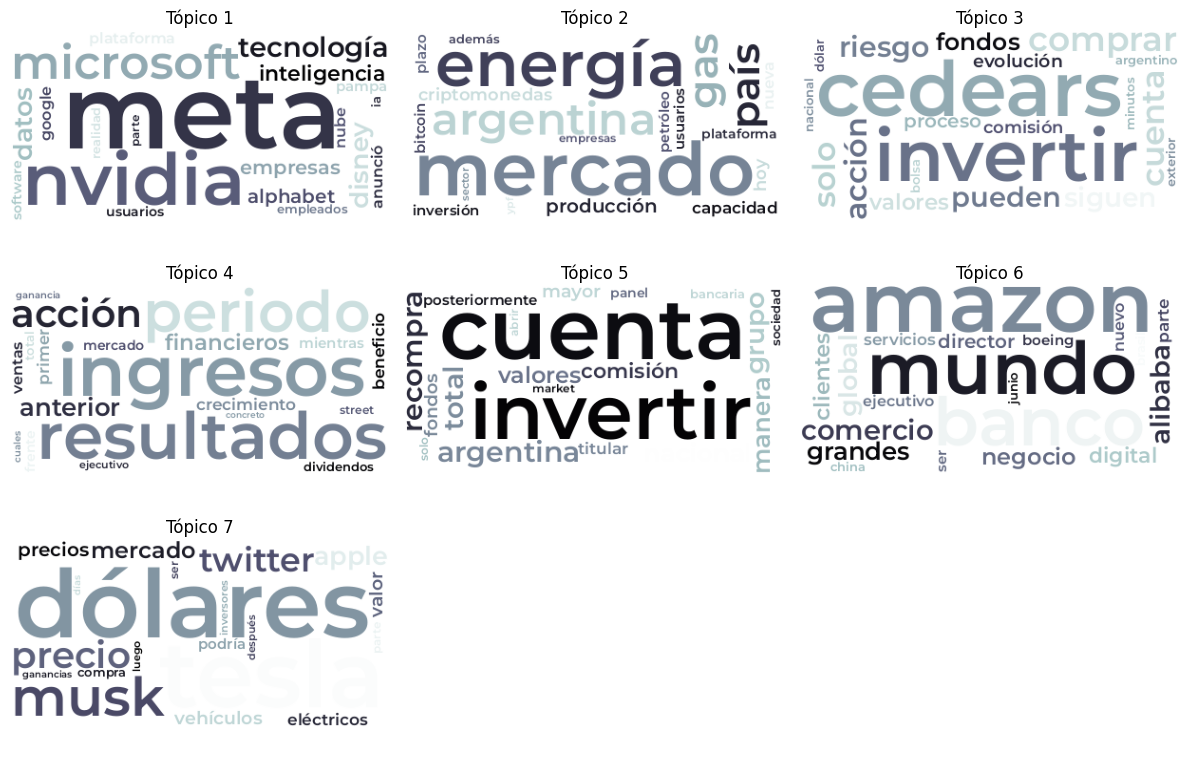

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

num_topics = len(best_model.show_topics())  # Número total de tópicos
num_rows = (num_topics + 2) // 3  # Número de filas, ajustado para mostrar tres registros por fila

fig, axs = plt.subplots(num_rows, 3, figsize=(12, 8))  # Crear la figura con subplots, ajustar el tamaño según tus preferencias

for i in range(num_topics):
    row = i // 3  # Índice de fila
    col = i % 3  # Índice de columna

    axs[row, col].imshow(WordCloud(background_color='white', prefer_horizontal=0, colormap='bone', font_path='/content/drive/MyDrive/Colab Notebooks/Trabajo Text Mining/Fuentes/Montserrat-SemiBold.ttf')
                         .fit_words(dict(best_model.show_topic(i, 20))))
    axs[row, col].axis("off")
    axs[row, col].set_title("Tópico " + str(i+1))

# Eliminar los subplots vacíos si el número de tópicos no es múltiplo de 3
if num_topics % 3 != 0:
    empty_cols = 3 - (num_topics % 3)
    for i in range(empty_cols):
        axs[-1, -(i+1)].axis("off")

plt.tight_layout()  # Ajustar el diseño de los subplots
plt.show()  # Mostrar la figura con los subplots



> ### **Frecuencia de los tópicos**



In [ ]:
import plotly.graph_objects as go

# Obtener la distribución de tópicos para cada documento
topic_distribution = [best_model.get_document_topics(doc) for doc in corpus]

# Obtener la probabilidad del tópico dominante para cada documento
dominant_topic = [max(topics, key=lambda x: x[1])[0] for topics in topic_distribution]

# Contar la cantidad de documentos por tópico
topic_counts = np.bincount(dominant_topic)

# Lista de nombres de los tópicos
topic_names = [f'Tópico {i+1}' for i in range(best_model.num_topics)]

# Crear el gráfico de anillos
fig = go.Figure(data=go.Pie(
    labels=[],
    values=topic_counts,
    hole=0.4,  # Tamaño del agujero central
    marker=dict(colors=['#1abc9c', '#95a5a6']),  # Colores de los sectores
))

# Actualizar la leyenda con los nombres de los tópicos
labels = []
for i, name in enumerate(topic_names):
    labels.append(f"{name}: {topic_counts[i]}")
fig.update_traces(labels=labels)

# Personalizar el diseño del gráfico
fig.update_layout(
    template="plotly_white",  # Fondo blanco
    title='Distribución de Tópicos',
    width=700
)

# Mostrar el gráfico
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



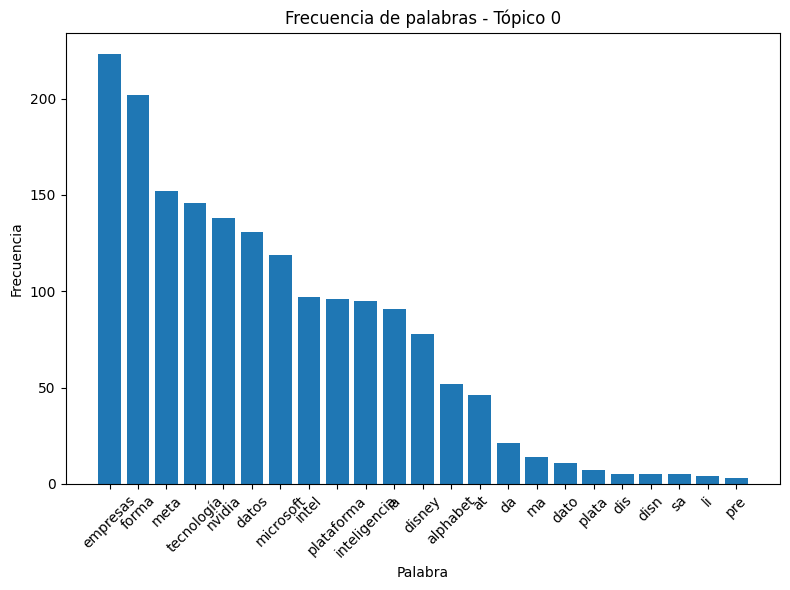

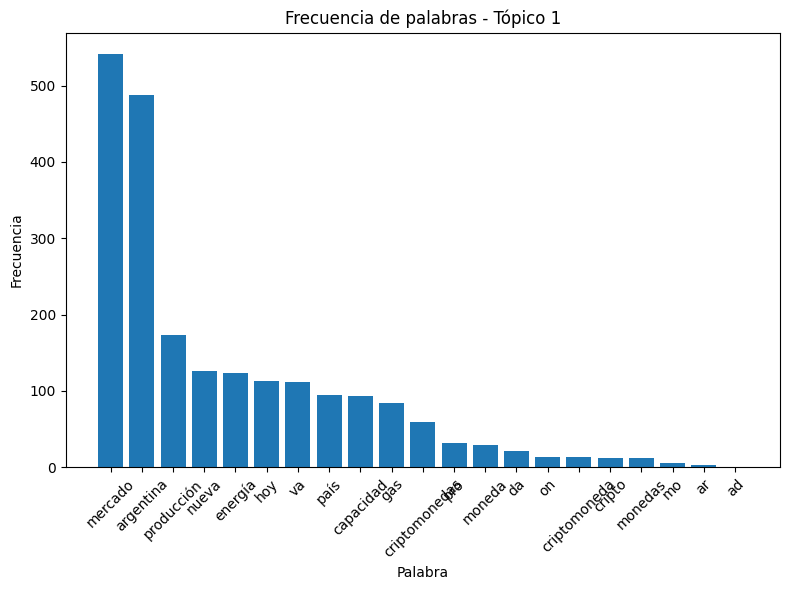

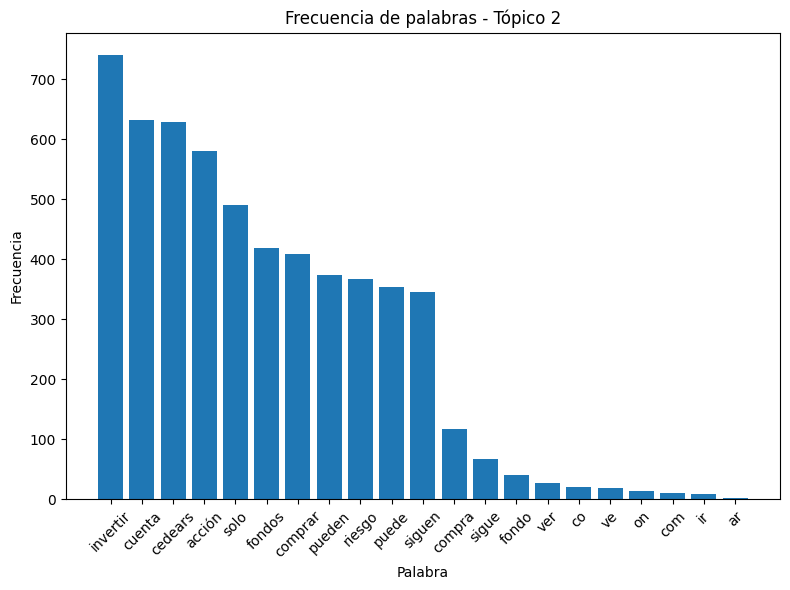

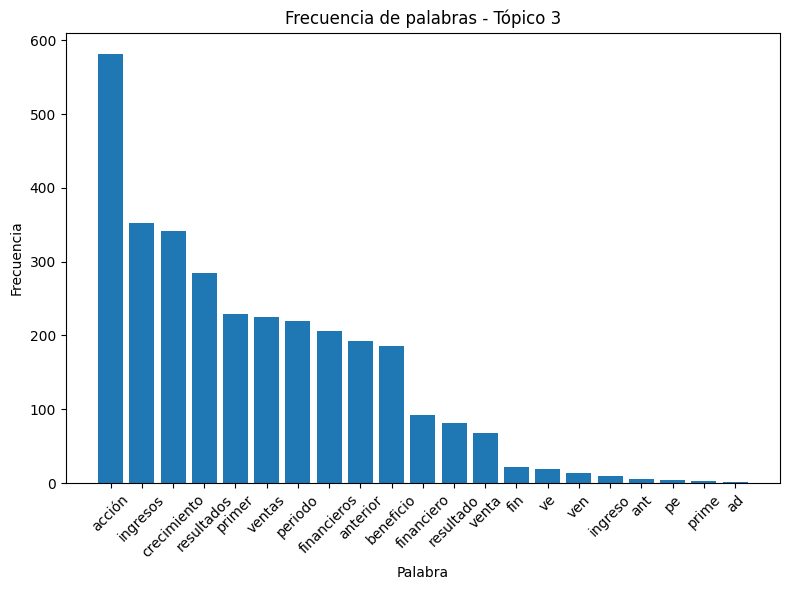

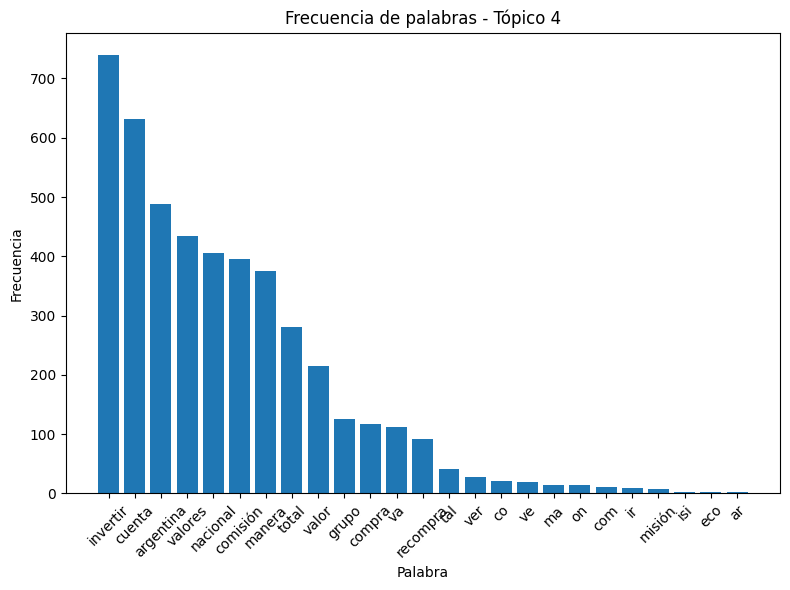

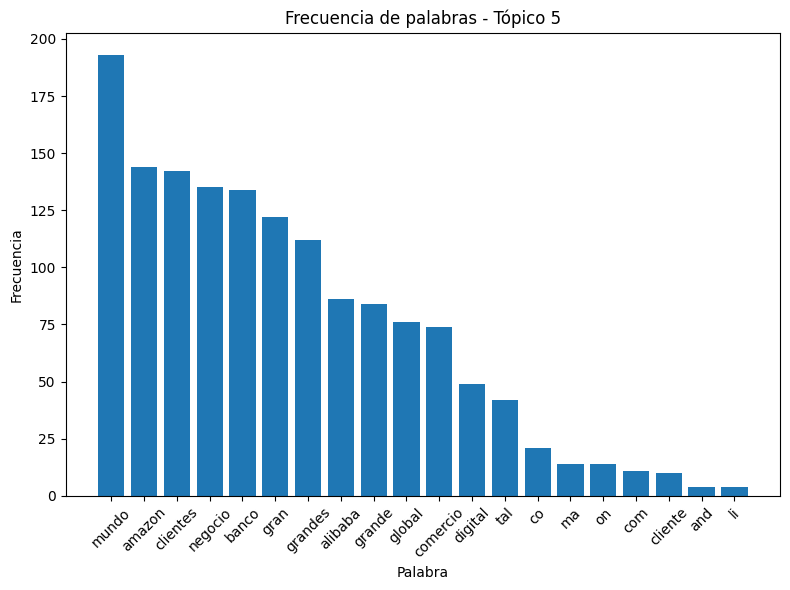

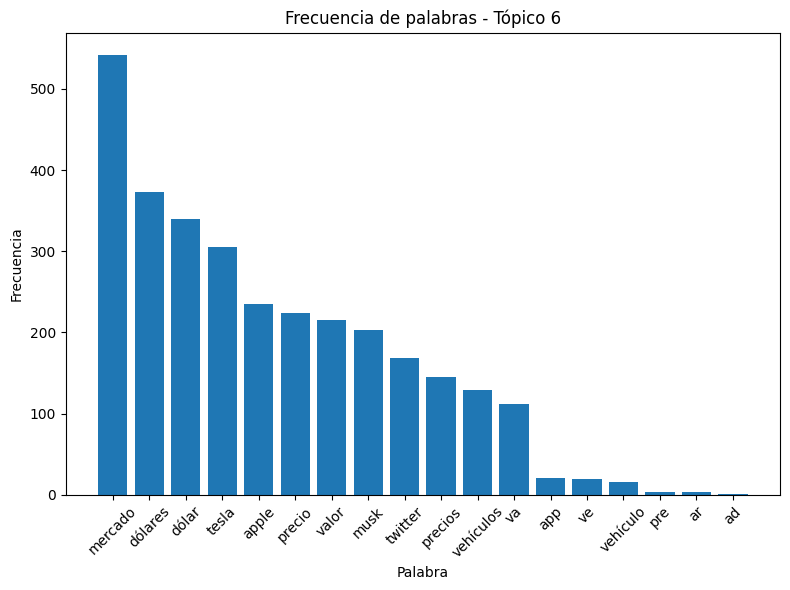

In [ ]:
import matplotlib.pyplot as plt

# Obtener las palabras clave de cada tópico
palabras_clave = best_model.show_topics(num_topics=8, num_words=10)

# Crear un diccionario para almacenar las frecuencias de palabras por tópico
frecuencias_topicos = {}

# Calcular las frecuencias de palabras por tópico
for topico_id, palabras in palabras_clave:
    frecuencias_topicos[topico_id] = {}

    for documento in corpus:
        for palabra_id, frecuencia in documento:
            palabra = diccionario[palabra_id]

            if palabra in palabras:
                if palabra in frecuencias_topicos[topico_id]:
                    frecuencias_topicos[topico_id][palabra] += frecuencia
                else:
                    frecuencias_topicos[topico_id][palabra] = frecuencia

# Generar el gráfico de frecuencia de palabras por tópico
for topico_id, frecuencias in frecuencias_topicos.items():
    palabras = list(frecuencias.keys())
    valores = list(frecuencias.values())

    # Ordenar las palabras y valores por frecuencia descendente
    palabras_ordenadas, valores_ordenados = zip(*sorted(zip(palabras, valores), key=lambda x: x[1], reverse=True))

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    plt.bar(palabras_ordenadas, valores_ordenados)
    plt.xticks(rotation=45)
    plt.xlabel('Palabra')
    plt.ylabel('Frecuencia')
    plt.title(f'Frecuencia de palabras - Tópico {topico_id}')
    plt.tight_layout()
    plt.show()

## **Validación del modelo**

 Mercado Libre (MELI) es una plataforma de comercio en línea que ofrece una amplia variedad de productos y servicios para comprar y vender. Los usuarios pueden crear sus propios anuncios para vender productos, o comprar productos de otros vendedores. En los últimos años, MELI se ha convertido en uno de los sitios de comercio electrónico más populares de América Latina, y tiene presencia en varios países de la región como Brasil y Chile. El sitio cuenta con millones de usuarios activos, y se espera que siga creciendo en el futuro. Además de los productos y servicios tradicionales que se ofrecen en un sitio de comercio electrónico, la empresa también cuenta con la plataforma de pagos más importante de la región, Mercado Pago, que permite a los usuarios realizar transacciones en línea de forma segura y eficiente. Luego de varios meses de baja, donde el precio de sus acciones descendieron en un 70% desde los USD 2000 hasta los USD 600 aproximadamente, las acciones de Mercado Libre llevan v

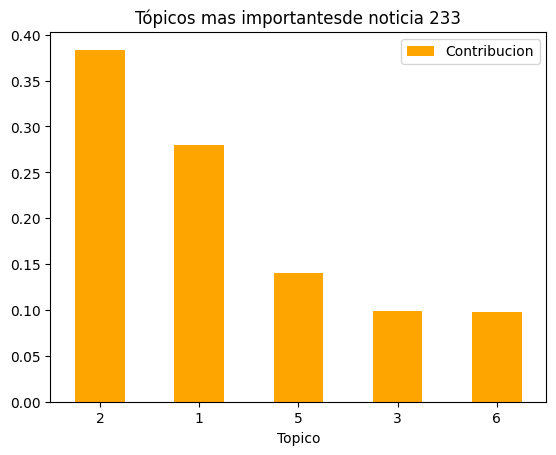

In [ ]:
# Se empieza escogiendo un comentario del corpus al azar y mostramos su contenido

indice_noticia = random.randint(0,len(df))
noticia = df.iloc[indice_noticia]
print(noticia.description)

# Primero debemos obtener la representación BOW del documento y la distribución de los tópicos:

bow_noticia = corpus[indice_noticia]
distribucion_noticia = best_model[bow_noticia]

# Luego, sacamos los índices y la contribución (proporción) de los tópicos más significativos para
# nuestra noticia y los mostramos en un gráfico de barras para un mejor entendimiento.

# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in best_model[bow_noticia]]

# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in best_model[bow_noticia]]
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion',
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico',
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes'
                                   'de noticia ' + str(indice_noticia))